In [3]:
import pandas as pd
import numpy as np
import os
import datetime
from keras import models
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,ReLU,Softmax, BatchNormalization
from keras.models import Sequential
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard 
from keras.preprocessing import image
import seaborn as sns
import tensorflow as tf
import random as rd
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
train_folder = 'ML_dataset/train/images/'
evaluation_folder = 'ML_dataset/evaluation/images/'

In [7]:
# for folder in os.listdir('ML_dataset/train/images'):
#     for img in os.listdir('ML_dataset/train/images/' + folder):
#         os.rename('ML_dataset/train/images/' + folder + '/' + img, 'ML_dataset/train/images/' + img)

In [8]:
# for folder in os.listdir('ML_dataset/evaluation/images'):
#     for img in os.listdir('ML_dataset/evaluation/images/' + folder):
#         os.rename('ML_dataset/evaluation/images/' + folder + '/' + img, 'ML_dataset/evaluation/images/' + img)

In [9]:
labels_df = pd.read_csv('ML_dataset/train/labels/train_data_label.csv', index_col = 0)

In [10]:
filenames = pd.DataFrame(os.listdir('ML_dataset/train/images'), index=[int(fname.split('_')[0]) for fname in os.listdir('ML_dataset/train/images')])

In [11]:
labels_df = labels_df.join(filenames).sort_index()

In [12]:
labels_df.columns = ['TYPE', 'img']

In [13]:
for timeline in labels_df['TYPE'].unique():
    os.mkdir('ML_dataset/train/images/' + timeline)

In [14]:
for row in labels_df.iterrows():
    os.rename('ML_dataset/train/images/' + row[1][1], 'ML_dataset/train/images/' + row[1][0] + '/' + row[1][1])

In [15]:
labels_df = pd.read_csv('ML_dataset/evaluation/labels/evaluation_data_label.csv', index_col = 0)

In [16]:
filenames = pd.DataFrame(os.listdir('ML_dataset/evaluation/images'), index=[int(fname.split('_')[0]) for fname in os.listdir('ML_dataset/evaluation/images')])

In [17]:
labels_df = labels_df.join(filenames).sort_index()
labels_df.columns = ['TYPE', 'img']

In [18]:
for timeline in labels_df['TYPE'].unique():
    os.mkdir('ML_dataset/evaluation/images/' + timeline)

In [19]:
for row in labels_df.iterrows():
    os.rename('ML_dataset/evaluation/images/' + row[1][1], 'ML_dataset/evaluation/images/' + row[1][0] + '/' + row[1][1])

In [33]:
num_skipped = 0
for main_folder in ("ML_dataset/train/images", "ML_dataset/evaluation/images"):
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 68 images


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'ML_dataset/train/images',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        'ML_dataset/evaluation/images',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 7872 images belonging to 3 classes.
Found 1966 images belonging to 3 classes.


In [11]:
# Creating a Sequential model
model = Sequential()
# Add a first convolution layer and specify the first input shape, and set the activation function as Rectified Linear Unit
model.add(Conv2D(kernel_size=(3,3), filters=64, input_shape=(224,224,3), strides=(1,1), activation='relu', padding='same'))
# Add a BatchNormalization layer to avoid overfitting 
model.add(BatchNormalization())
# Add a MaxPooling layer to shrink the picture
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=128,kernel_size = (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=256,kernel_size = (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=512,kernel_size = (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
# Flatten the tensor to modify its shape to 1D for the Dense layer
model.add(Flatten())
# Add a Dense layer of 512 neurons
model.add(Dense(512))
# Add a Dropout layer to avoid overfitting
model.add(Dropout(0.2))
# Add another Dense layer with a number of neurons equal to the number of labels!
model.add(Dense(3))
# In the end, pass the input through a Softmax layer (Softmax is required when the categories to predict are > 2)
model.add(Softmax())

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_4 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 256)      

In [13]:
checkpoint = ModelCheckpoint('saved_models/model_{epoch}', save_best_only=True, monitor='val_acc')

LR_reduce = ReduceLROnPlateau(patience=3, min_delta=0.02, min_lr=0.00001)

early_stopper = EarlyStopping(patience=5, min_delta=0.01)

labels_count = dict()
for img_class in [ic for ic in os.listdir(train_folder) if ic[0] != '.']:
    labels_count[img_class] = len(os.listdir(train_folder + img_class))
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in 
                 enumerate(labels_count.values())}

class_weights

{0: 2.49746192893401, 1: 2.1769911504424777, 2: 7.130434782608695}

In [14]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(
              loss='categorical_crossentropy', 
              metrics=['acc'],
              optimizer=RMSprop(0.01)
             )

# Training the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 246,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=62,
    verbose=2,
    class_weight=class_weights,
    callbacks=[tensorboard_callback, checkpoint, LR_reduce])

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/model_1\assets
246/246 - 167s - loss: 851.7568 - acc: 0.5725 - val_loss: 3.1969 - val_acc: 0.7442 - lr: 0.0100
Epoch 2/50
246/246 - 176s - loss: 105.4357 - acc: 0.6143 - val_loss: 10.6057 - val_acc: 0.6307 - lr: 0.0100
Epoch 3/50
246/246 - 168s - loss: 76.9343 - acc: 0.6672 - val_loss: 5.1803 - val_acc: 0.7421 - lr: 0.0100
Epoch 4/50
246/246 - 155s - loss: 78.6243 - acc: 0.6954 - val_loss: 3.2436 - val_acc: 0.6338 - lr: 0.0100
Epoch 5/50
INFO:tensorflow:Assets written to: saved_models/model_5\assets
246/246 - 159s - loss: 2.6304 - acc: 0.8092 - val_loss: 0.5364 - val_acc: 0.8057 - lr: 1.0000e-03
Epoch 6/50
INFO:tensorflow:Assets written to: saved_models/model_6\assets
246/246 - 159s - loss: 1.4383 - acc: 0.8363 - val_loss: 0.4337 - val_acc: 0.8327 - lr: 1.0000e-03
Epoch 7/50
INFO:tensorflow:Assets written to: saved_models/model_7\assets
246/246 - 1

KeyboardInterrupt: 

In [5]:
final_model = models.load_model("saved_models/model_12")

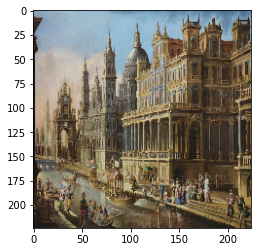

(1, 224, 224, 3)


In [33]:
images = os.listdir('ML_dataset/validation')
img = image.load_img('ML_dataset/validation/' + rd.choice(images), target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [34]:
final_model(img_tensor, training=False)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[9.9822468e-01, 1.2439471e-03, 5.3127616e-04]], dtype=float32)>

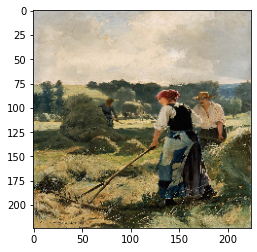

(1, 224, 224, 3)


In [33]:
img_path = 'ML_dataset/train/images/genre/8503_haymakin.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [34]:
# predicting images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict_classes(images, batch_size=32)
print("Predicted class is:",classes)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Predicted class is: [1]


In [35]:
layer_outputs = [layer.output for layer in model.layers] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [36]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

In [37]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 222, 222, 64)


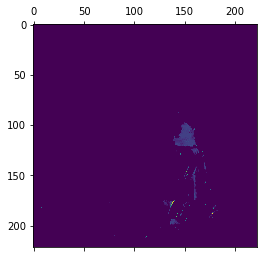

In [38]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

C:\Users\slim_\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\slim_\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


MemoryError: Unable to allocate 2.85 PiB for an array with shape (339738624, 1179648) and data type float64

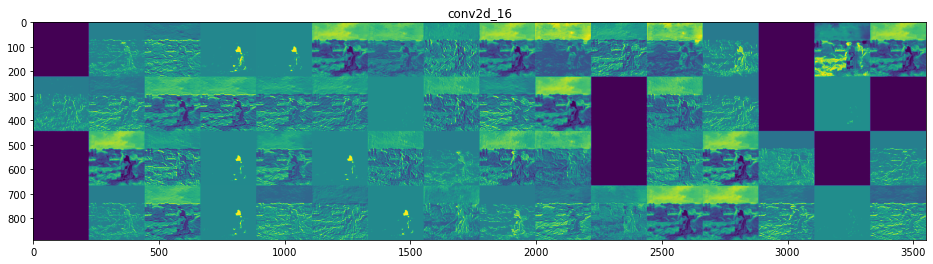

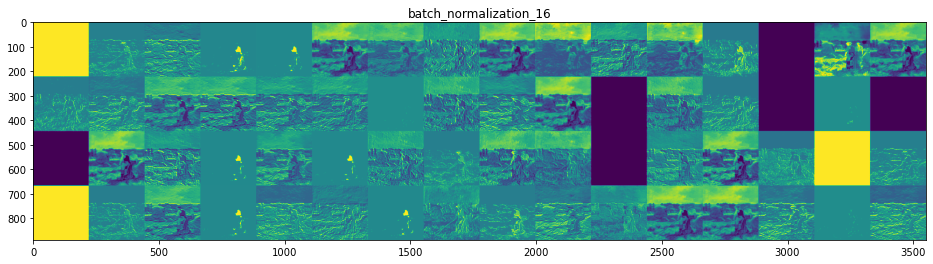

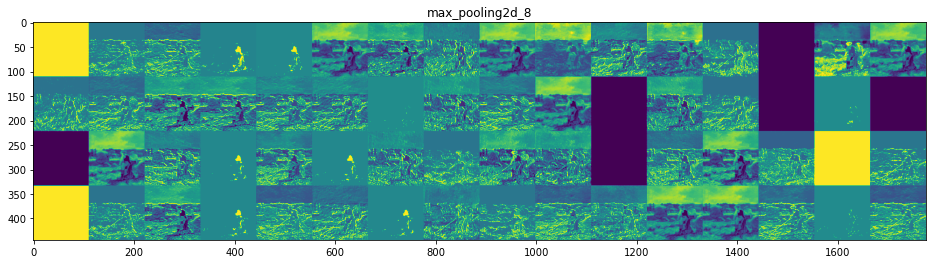

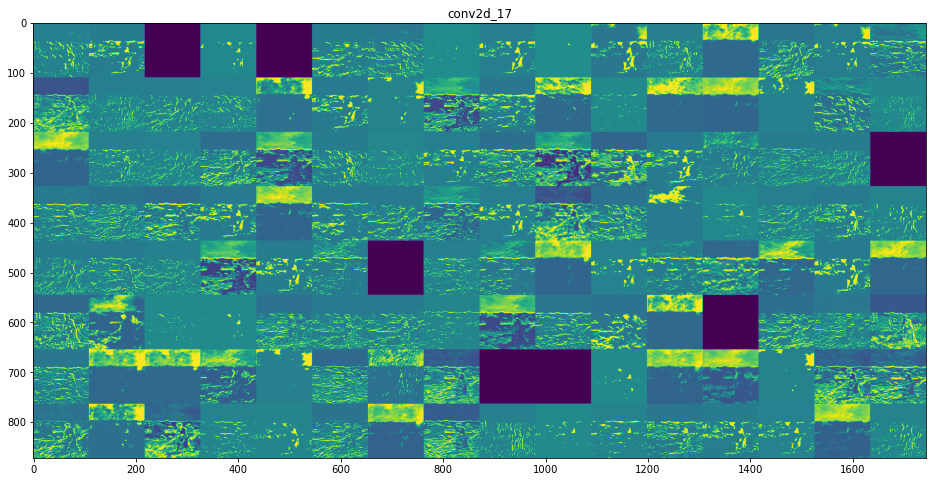

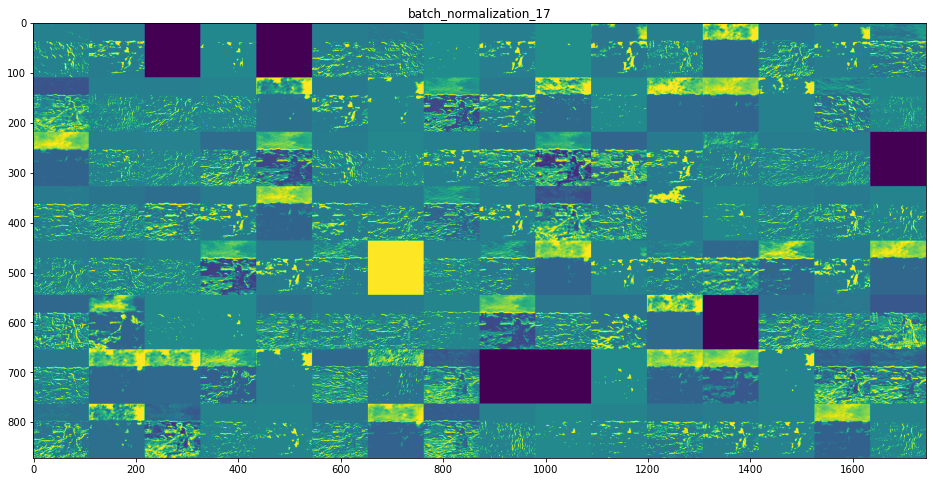

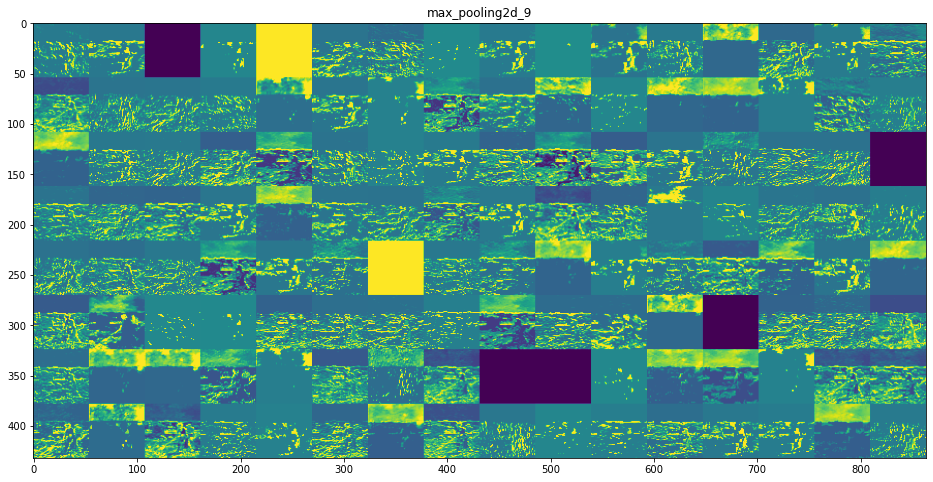

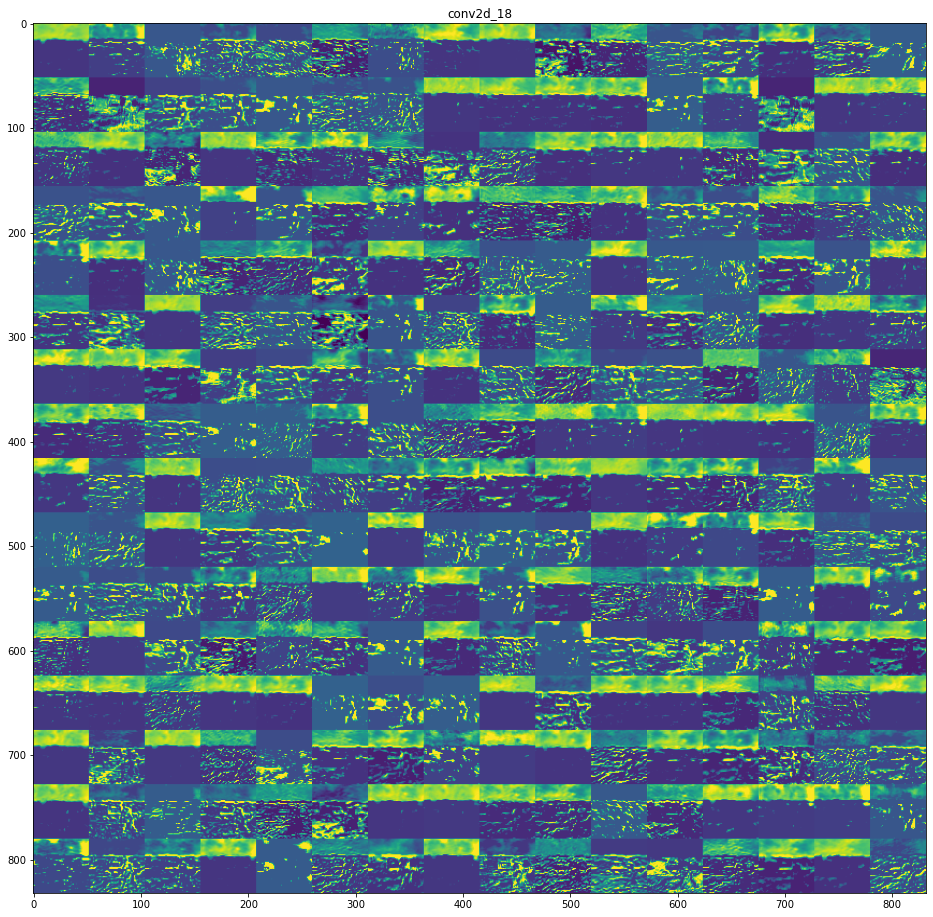

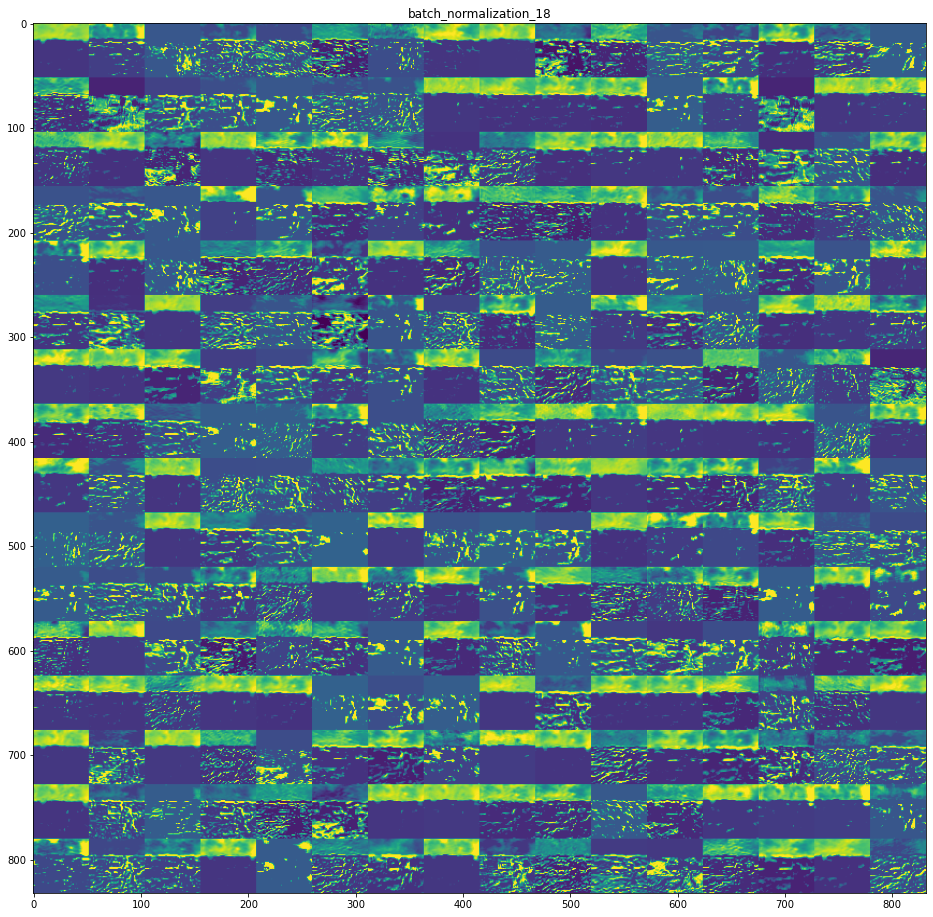

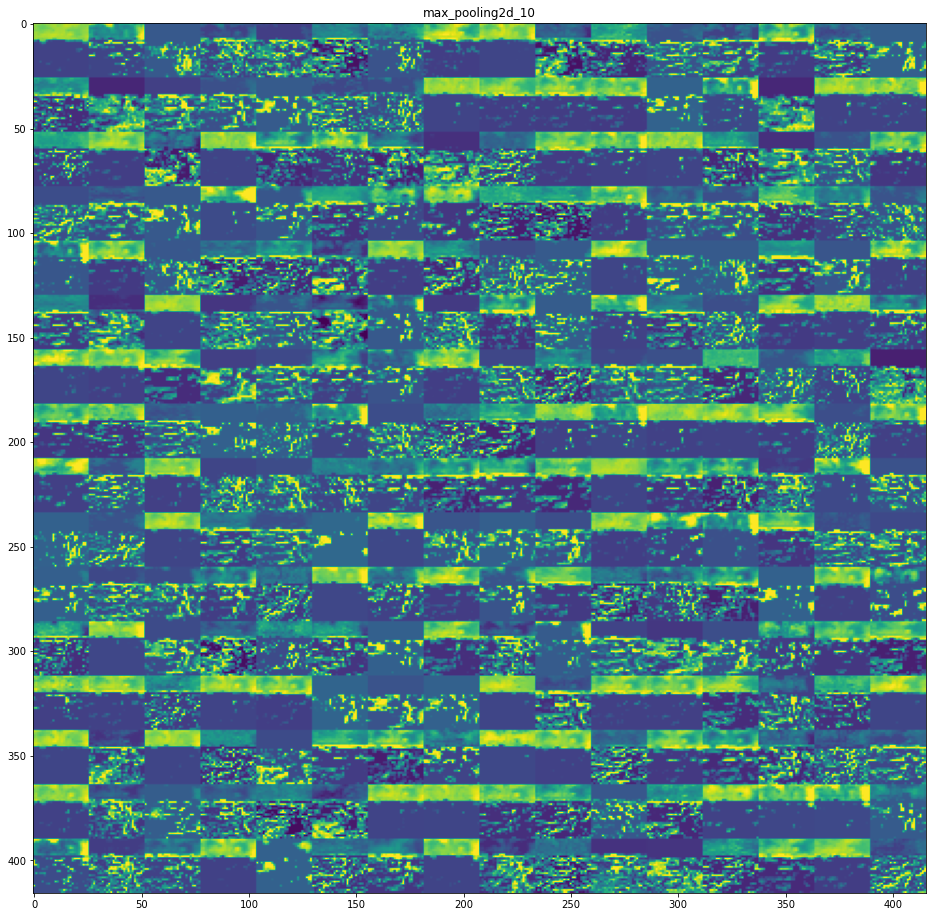

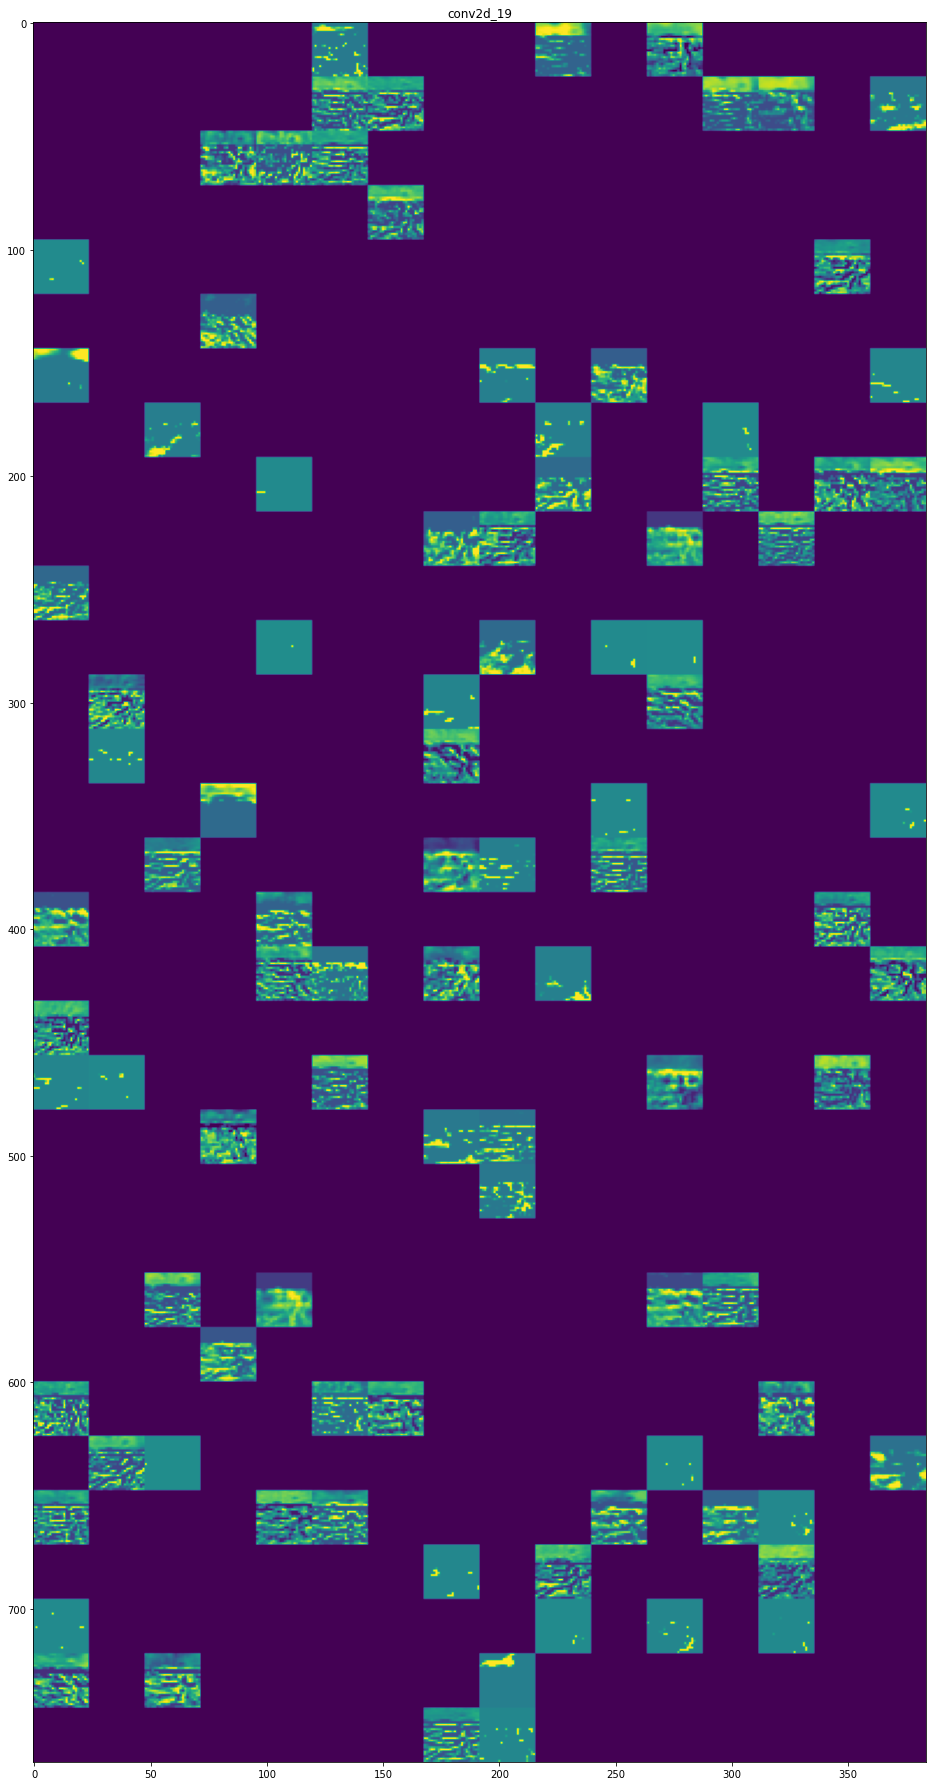

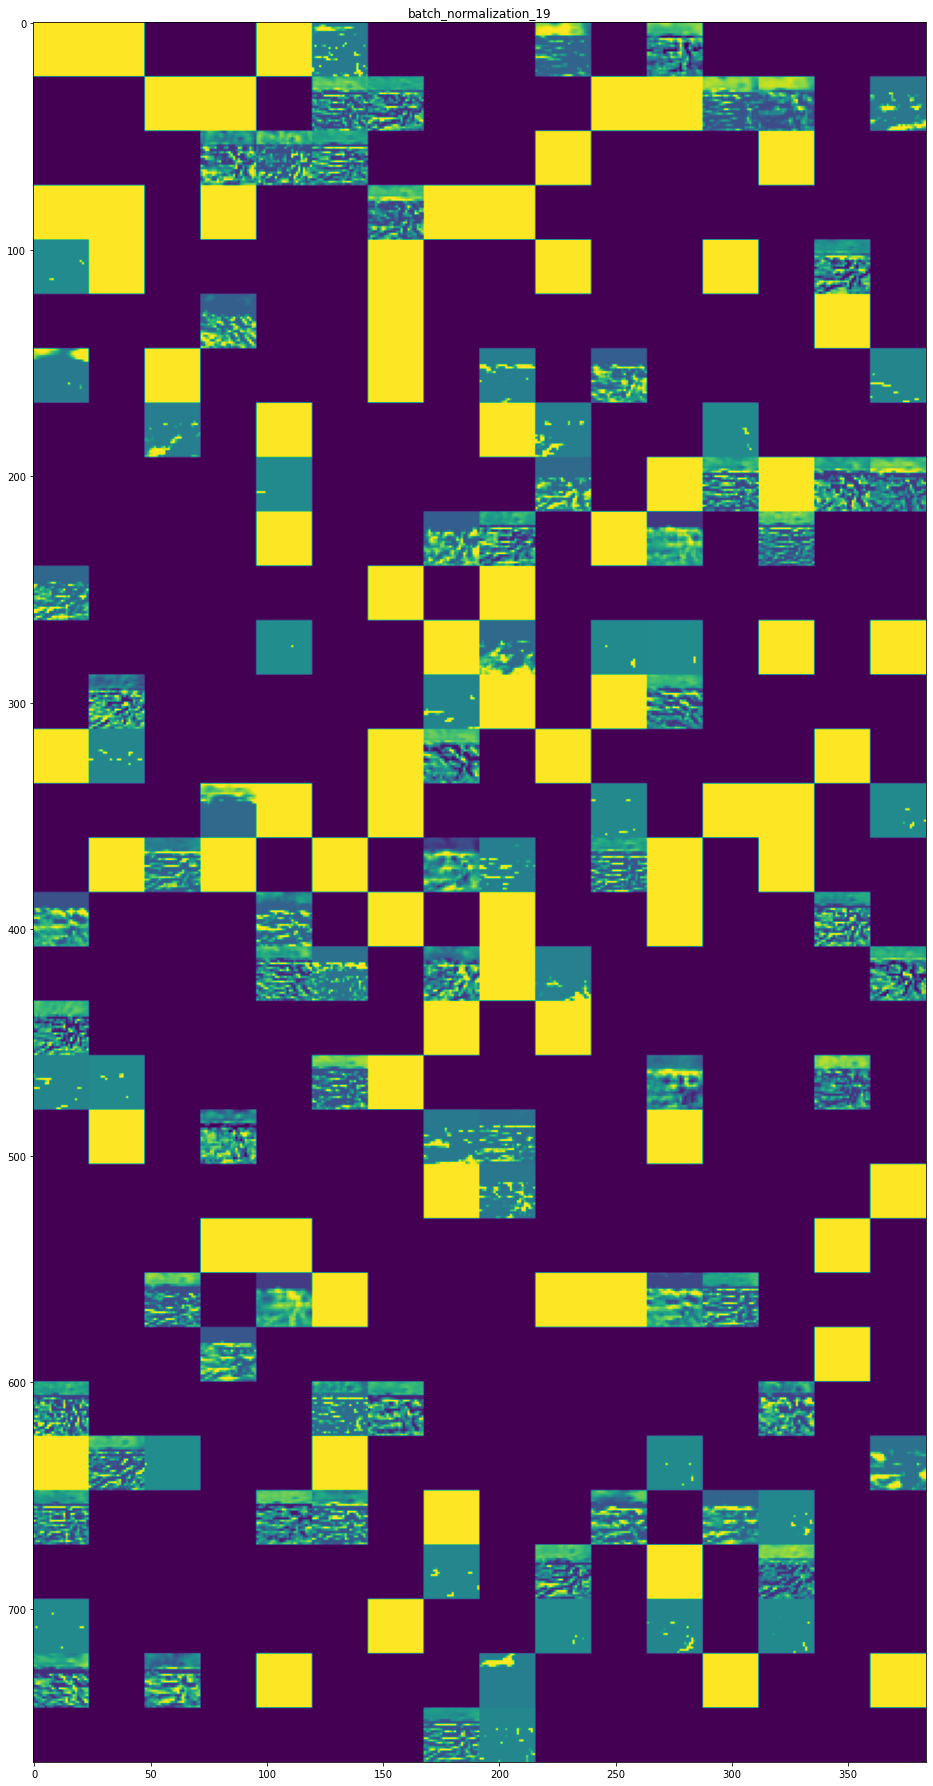

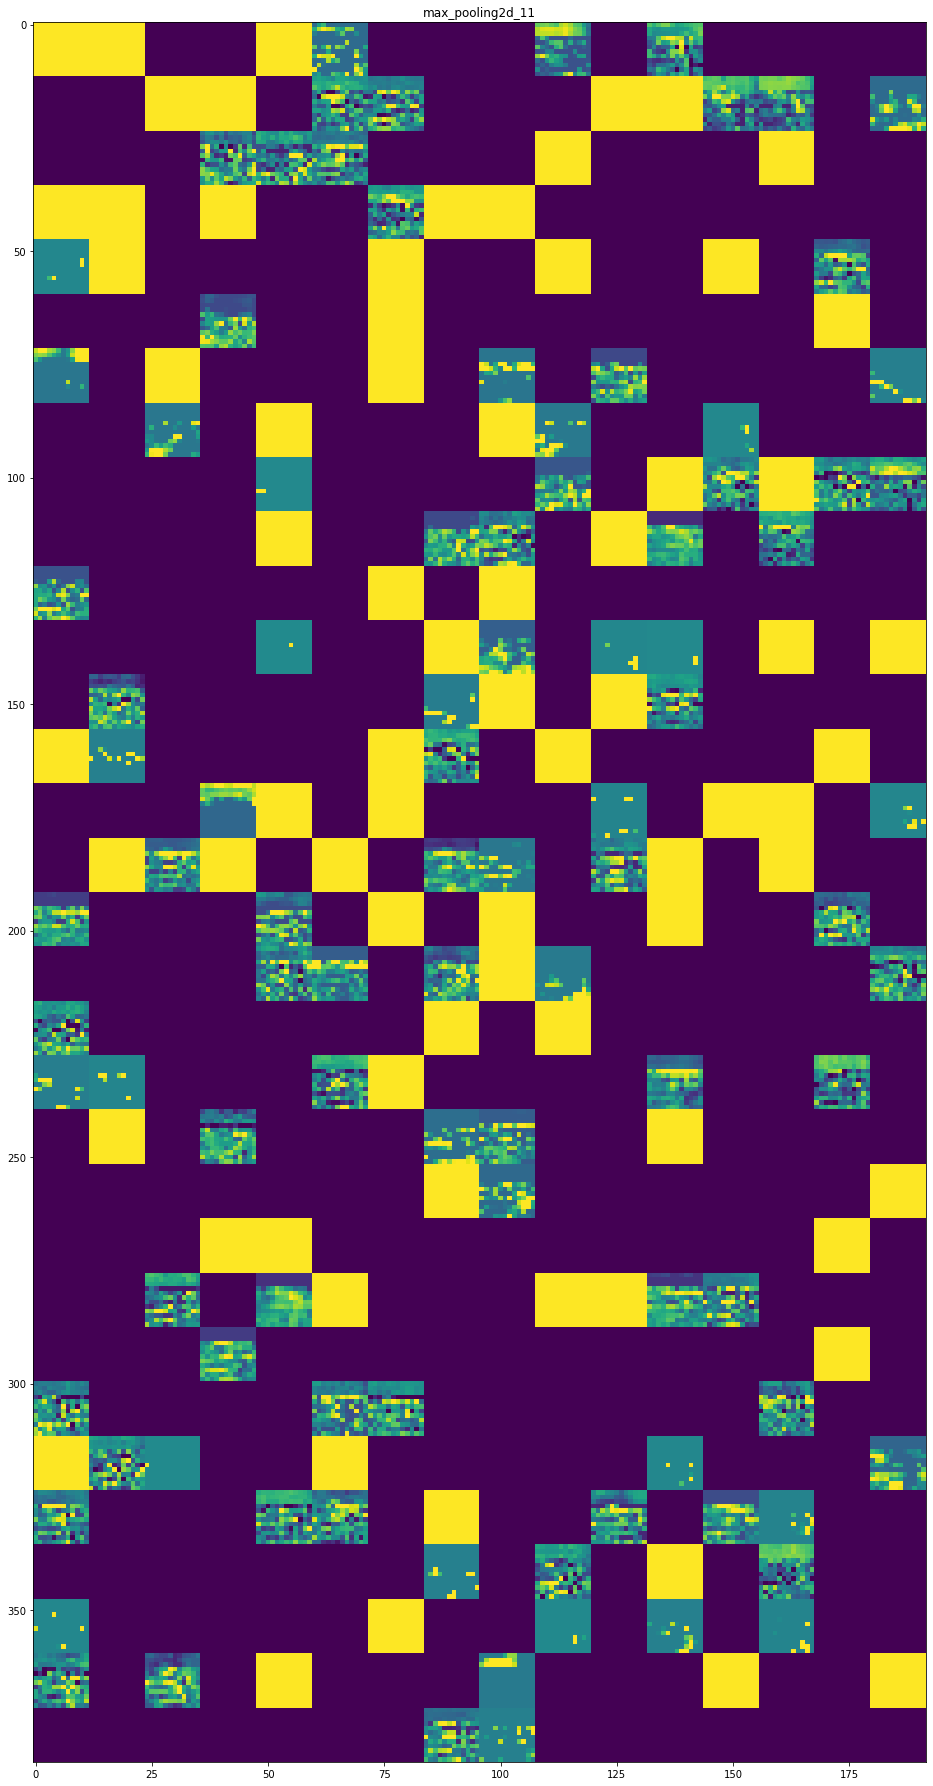

In [39]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')